In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

train_data = pd.read_excel("data/train.xlsx")
test_data = pd.read_excel("data/test.xlsx")

In [8]:
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Извлечение признаков из даты
for data in [train_data, test_data]:
    data["dt"] = pd.to_datetime(data["dt"])
    data["year"] = data["dt"].dt.year
    data["month"] = data["dt"].dt.month
    data["day"] = data["dt"].dt.day
    data["dayofweek"] = data["dt"].dt.dayofweek
    data["week"] = data["dt"].dt.isocalendar().week

# Признаки (X) и целевая переменная (y)
X = train_data.drop(columns=["Price"], errors="ignore")  # Удаляем дату и целевую переменную
y = train_data["Price"]

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

try:
    # Попытка загрузить обученную модель
    model = joblib.load("xgboost_model.pkl")
    print("Модель загружена из файла.")
except FileNotFoundError:
    # Если файл не найден, обучаем новую модель
    print("Файл модели не найден. Обучаем новую модель.")
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        reg_lambda=10,
        verbosity=1,
        tree_method="hist"  # Исправление ошибки __sklearn_tags__
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],  # Валидация
        verbose=10
    )
    # Сохранение обученной модели
    joblib.dump(model, "xgboost_model.pkl")
    print("Обученная модель сохранена в 'xgboost_model.pkl'.")

# Прогнозирование на тестовых данных
X_test = test_data.drop(columns=["Price", "dt"], errors="ignore")  # Удаляем ненужные столбцы
y_test = test_data["Price"]

y_pred = model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Сохранение результатов в CSV
test_data = test_data.iloc[:len(y_pred)]  # Подгоняем размерность
test_data["predicted_price"] = y_pred
test_data.to_csv("test_with_predictions.csv", index=False)

print("Результаты сохранены в 'test_with_predictions.csv'.")


Модель загружена из файла.
MAE: 14019.1702
RMSE: 16060.0871
R²: -19.1219
Результаты сохранены в 'test_with_predictions.csv'.


C:\Users\Виктор\AppData\Local\Temp\ipykernel_20440\3611898631.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["predicted_price"] = y_pred


In [9]:
print(test_data.columns)

Index(['dt', 'Price', 'year', 'month', 'day', 'dayofweek', 'week',
       'predicted_price'],
      dtype='object')


In [10]:
import joblib
import pandas as pd

# Загрузка модели
model = joblib.load("xgboost_model.pkl")

print("Столбцы в test_data до обработки:", test_data.columns)

# Проверяем, есть ли 'Price' в данных
if 'Price' in test_data.columns:
    X_test = test_data.drop(columns=["Price"]).copy()  # Убираем 'Price'
else:
    raise KeyError("Столбец 'Price' отсутствует в данных.")

# ❗ Убираем 'recommended_weeks', если он уже есть
X_test = X_test.drop(columns=["recommended_weeks"], errors="ignore")

# Проверяем соответствие признаков
expected_features = model.feature_names_in_  # Получаем признаки, с которыми обучалась модель
X_test = X_test[expected_features]  # Оставляем только нужные столбцы

# Прогнозирование
test_predictions = model.predict(X_test)

# Добавляем прогнозы в исходные данные
test_data["predicted_price"] = test_predictions

print("Данные с прогнозами:")
print(test_data.head())

# Функция для рекомендации количества недель закупки
def recommend_purchase_weeks(predicted_price, current_price):
    return 6 if predicted_price > current_price else 1  # 6 недель или 1 неделя

# Проверяем наличие 'Price' перед расчетами
if 'Price' in test_data.columns:
    test_data["recommended_weeks"] = test_data.apply(
        lambda row: recommend_purchase_weeks(row["predicted_price"], row["Price"]), axis=1
    )
else:
    raise KeyError("Столбец 'Price' отсутствует в данных.")

# Сохранение результатов
test_data.to_csv("test_with_predictions.csv", index=False)
print("Результаты сохранены в файл 'test_with_predictions.csv'.")


Столбцы в test_data до обработки: Index(['dt', 'Price', 'year', 'month', 'day', 'dayofweek', 'week',
       'predicted_price'],
      dtype='object')
Данные с прогнозами:
          dt  Price  year  month  day  dayofweek  week  predicted_price
0 2022-09-05  46000  2022      9    5          0    36     44917.496094
1 2022-09-12  46000  2022      9   12          0    37     43411.902344
2 2022-09-19  46000  2022      9   19          0    38     43109.320312
3 2022-09-26  45500  2022      9   26          0    39     43166.417969
4 2022-10-03  45500  2022     10    3          0    40     45122.605469
Результаты сохранены в файл 'test_with_predictions.csv'.


C:\Users\Виктор\AppData\Local\Temp\ipykernel_20440\2160128660.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["predicted_price"] = test_predictions
C:\Users\Виктор\AppData\Local\Temp\ipykernel_20440\2160128660.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["recommended_weeks"] = test_data.apply(


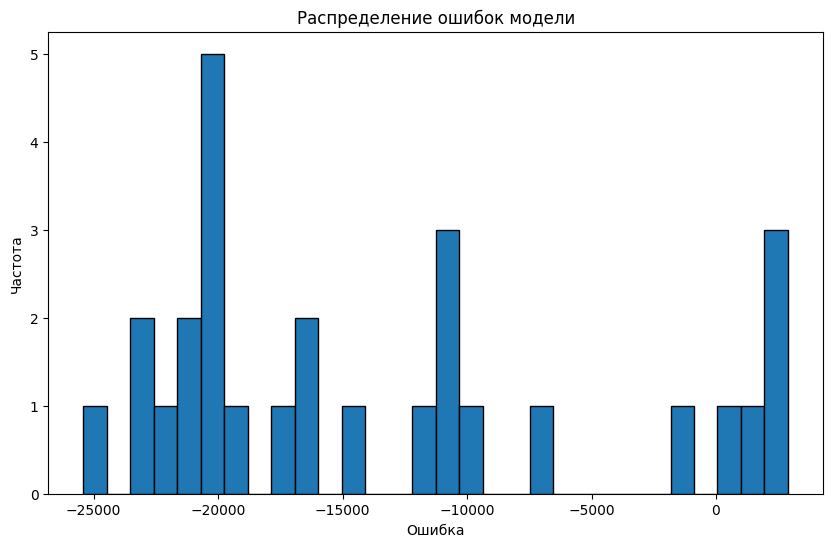

In [12]:
import matplotlib.pyplot as plt

# Ошибки модели
errors = y_test - y_pred

# Гистограмма ошибок
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Распределение ошибок модели")
plt.xlabel("Ошибка")
plt.ylabel("Частота")
plt.show()

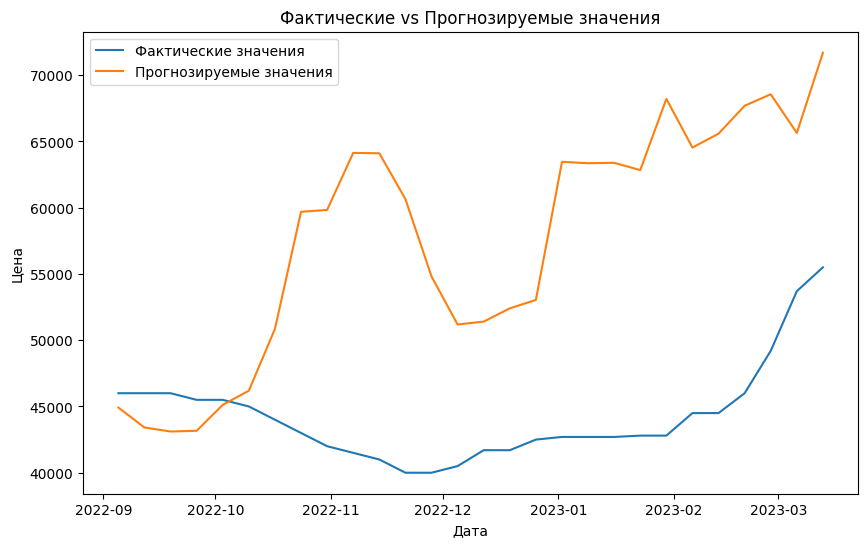

In [13]:
import matplotlib.pyplot as plt

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(test_data["dt"], y_test, label="Фактические значения")
plt.plot(test_data["dt"], y_pred, label="Прогнозируемые значения")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Фактические vs Прогнозируемые значения")
plt.legend()
plt.show()

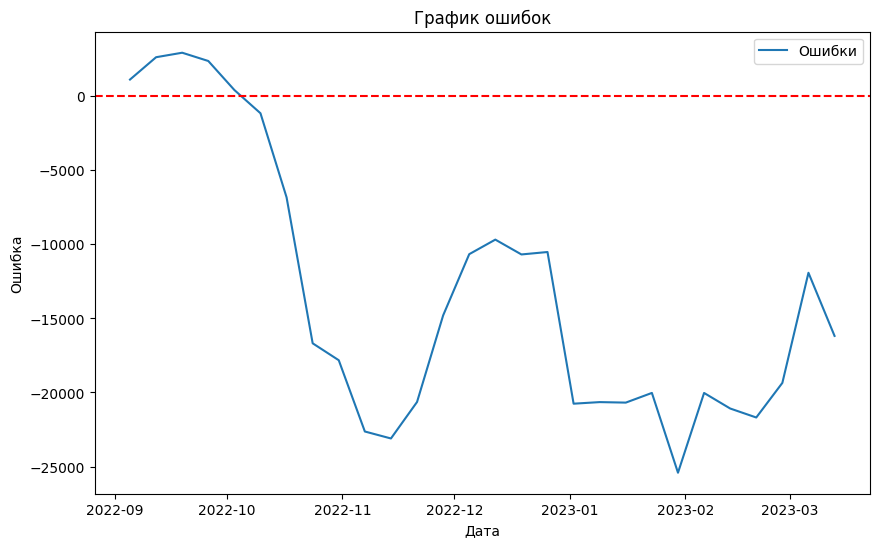

In [14]:
# Вычисляем ошибки
errors = y_test - y_pred

# Визуализация ошибок
plt.figure(figsize=(10, 6))
plt.plot(test_data["dt"], errors, label="Ошибки")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Дата")
plt.ylabel("Ошибка")
plt.title("График ошибок")
plt.legend()
plt.show()

In [15]:
import joblib
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Загружаем модель
model = joblib.load("xgboost_model.pkl")

# Проверяем типы данных
print("Типы данных X перед обработкой:\n", X.dtypes)

# Если есть 'dt', создаем числовые признаки и удаляем его
if 'dt' in X.columns:
    X["year"] = X["dt"].dt.year
    X["month"] = X["dt"].dt.month
    X["day"] = X["dt"].dt.day
    X["dayofweek"] = X["dt"].dt.dayofweek
    X["week"] = X["dt"].dt.isocalendar().week.astype(int)  # Приводим к int
    X = X.drop(columns=["dt"])  # Удаляем dt, так как XGBoost не поддерживает datetime

# Проверяем типы данных после обработки
print("Типы данных X после обработки:\n", X.dtypes)

# Кросс-валидация для временных рядов
tscv = TimeSeriesSplit(n_splits=2)
mae_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Прогнозирование с загруженной моделью
    y_pred = model.predict(X_test)
    
    # Оценка ошибки
    mae_scores.append(mean_absolute_error(y_test, y_pred))

print(f"Средний MAE по кросс-валидации: {np.mean(mae_scores)}")


Типы данных X перед обработкой:
 dt           datetime64[ns]
year                  int32
month                 int32
day                   int32
dayofweek             int32
week                 UInt32
dtype: object
Типы данных X после обработки:
 year         int32
month        int32
day          int32
dayofweek    int32
week         int64
dtype: object
Средний MAE по кросс-валидации: 499.8576054393797


In [16]:
import joblib
import pandas as pd

# Загружаем модель
model = joblib.load("xgboost_model.pkl")

# Количество недель для предсказания
N = 5

# Создаем столбец actual_price_after_N_weeks (цена через N недель)
test_data["actual_price_after_N_weeks"] = test_data["Price"].shift(-N)

# Удаляем строки, где нет будущей цены (чтобы не было NaN в target)
test_data = test_data.dropna(subset=["actual_price_after_N_weeks"])

# Проверяем, есть ли 'dt', и создаем числовые признаки из даты
if 'dt' in test_data.columns:
    test_data["year"] = test_data["dt"].dt.year
    test_data["month"] = test_data["dt"].dt.month
    test_data["day"] = test_data["dt"].dt.day
    test_data["dayofweek"] = test_data["dt"].dt.dayofweek
    test_data["week"] = test_data["dt"].dt.isocalendar().week.astype(int)
    test_data = test_data.drop(columns=["dt"])  # Удаляем dt

# Создаем копию test_data, но без целевой переменной
X_test = test_data.drop(columns=["Price", "actual_price_after_N_weeks"], errors="ignore")

# Оставляем только те признаки, которые использовались при обучении модели
X_test = X_test[model.feature_names_in_]  # Берем только обученные признаки

# Прогноз будущей цены через N недель
test_data["predicted_price_after_N_weeks"] = model.predict(X_test)

# Рекомендация (покупать на 6 недель, если цена растет, иначе на 1 неделю)
test_data["recommended_weeks"] = test_data.apply(
    lambda row: 6 if row["predicted_price_after_N_weeks"] > row["Price"] else 1, axis=1
)

# Фактическое изменение цены через N недель
test_data["price_change"] = test_data["actual_price_after_N_weeks"] - test_data["Price"]

# Оценка правильности рекомендаций
test_data["recommendation_correct"] = test_data.apply(
    lambda row: (row["price_change"] > 0 and row["recommended_weeks"] > 1) or
                (row["price_change"] <= 0 and row["recommended_weeks"] == 1),
    axis=1
)

# Доля правильных рекомендаций
accuracy = test_data["recommendation_correct"].mean()
print(f"Доля правильных рекомендаций: {accuracy * 100:.2f}%")


Доля правильных рекомендаций: 82.61%


C:\Users\Виктор\AppData\Local\Temp\ipykernel_20440\3708699500.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["actual_price_after_N_weeks"] = test_data["Price"].shift(-N)


<Axes: xlabel='dt', ylabel='Price'>

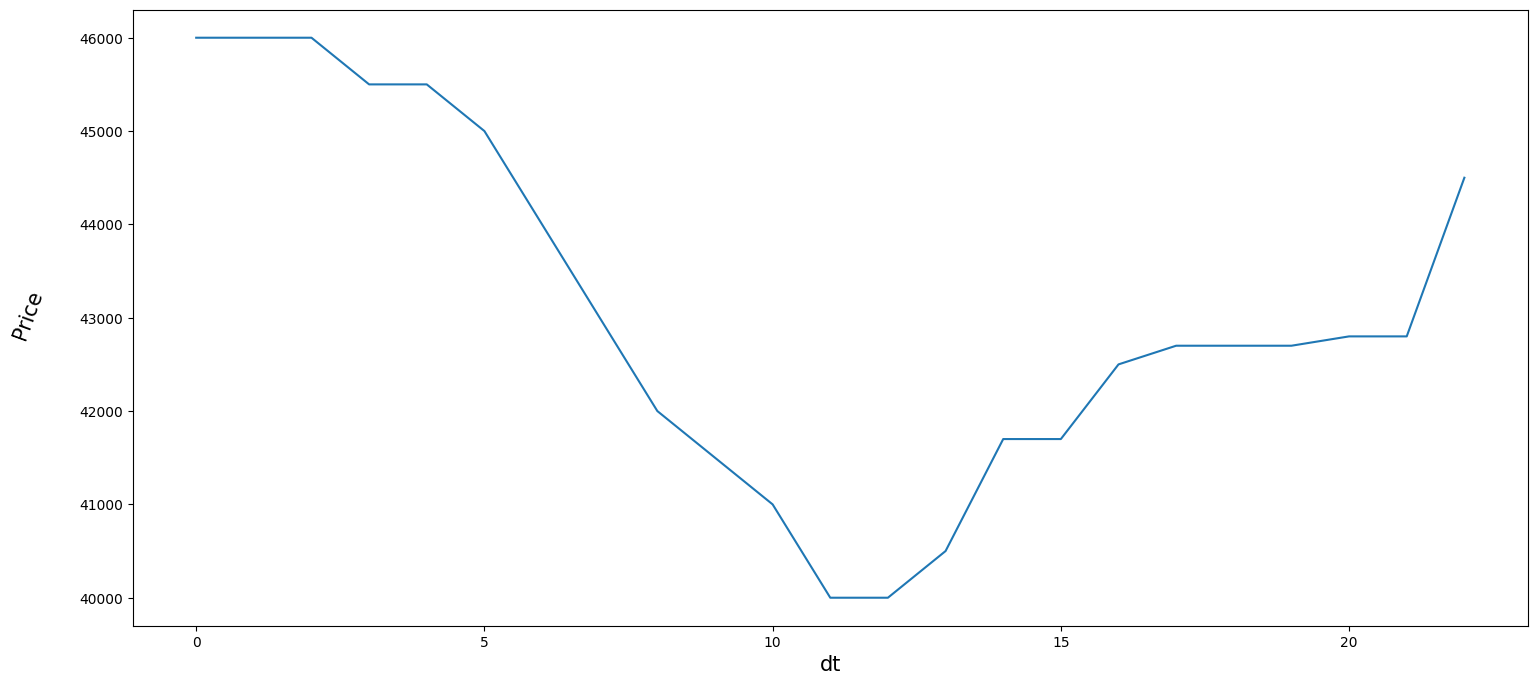

In [17]:
plt.figure(figsize=(18, 8))
plt.xlabel('dt', fontsize=15)
plt.ylabel('Price', rotation=70, labelpad=30, fontsize=15)
test_data["Price"].plot()